In [2]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [6]:
# --- Load Data ---
sept2013c3 = pd.read_csv('sept2013c3.csv')

# --- Data Preparation ---
X = sept2013c3.drop(columns=['Class'])
y = sept2013c3['Class']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Undersampling
under_sampler = RandomUnderSampler(sampling_strategy=0.002, random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

In [ ]:
# --- Random Forest Classifier (RFC) ---
rf_model = RandomForestClassifier(
    n_estimators=150, 
    random_state=42, 
    class_weight='balanced'
    )
rf_model.fit(X_resampled, y_resampled)

# Get RFC's probability predictions for the training set (for CNN input)
rf_train_prob = rf_model.predict_proba(X_resampled)
rf_test_prob = rf_model.predict_proba(X_test)

y_train_pred = rf_model.predict(X_resampled)
y_test_pred = rf_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, rf_test_prob[:, 1])

# Print all results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"\nClassification Report:\n{class_report}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

Train Accuracy: 1.0000
Test Accuracy: 0.9995
Confusion Matrix:
[[56861     3]
 [   24    74]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.76      0.85        98

    accuracy                           1.00     56962
   macro avg       0.98      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9615
Log Loss: 0.0057


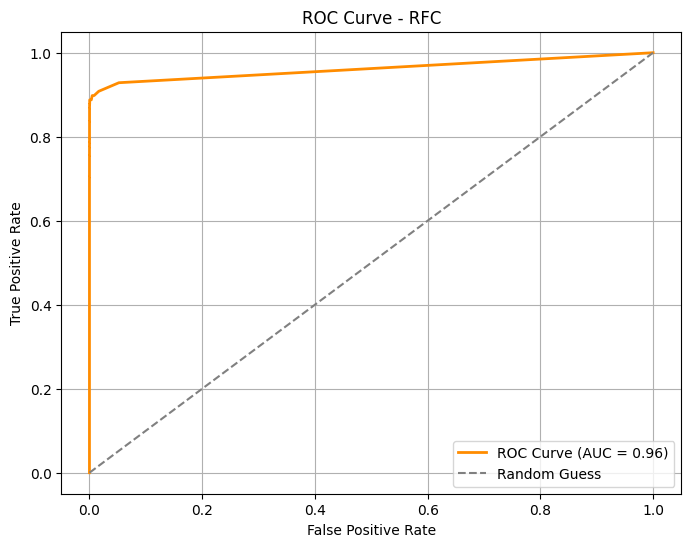

C:\Users\dhrus\AppData\Local\Temp\ipykernel_43140\2762168496.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(10), x='Importance', y='Feature', palette='viridis')


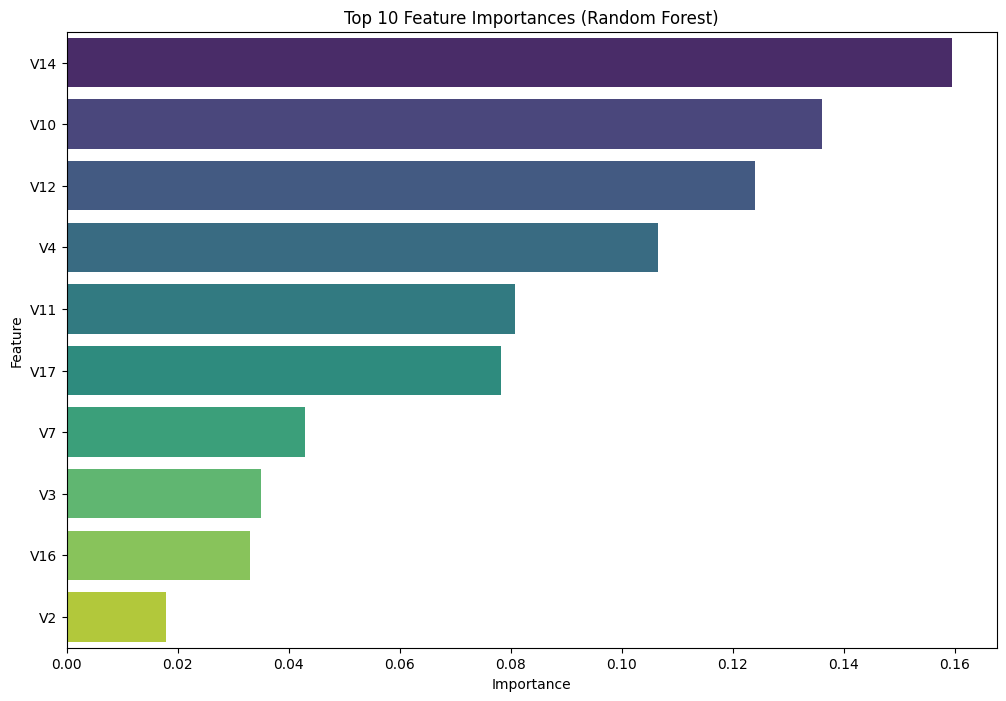

In [17]:
# Visualizing RF
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns

# Get probability predictions for the test set
rf_test_prob = rf_model.predict_proba(X_test)

# Get the probabilities for the positive class
y_probs = rf_test_prob[:, 1]

# Compute ROC curve and ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - RFC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plot feature importances
importances = rf_model.feature_importances_
# indices = np.argsort(importances)[::-1]
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()

# plt.figure(figsize=(10, 6))
# plt.title("Feature Importance - RFC")
# plt.barh(range(len(importances)), importances[indices], align="center")
# plt.yticks(range(len(importances)), X.columns[indices])
# plt.xlabel("Relative Importance")
# plt.show()

In [18]:
# Concatenate RFC probabilities to original data (this will be input to CNN)
X_resampled_combined = np.concatenate([X_resampled, rf_train_prob], axis=1)
X_test_combined = np.concatenate([X_test, rf_test_prob], axis=1)

# Reshape the data for the CNN (samples, time_steps, features)
X_resampled_combined = X_resampled_combined.reshape((X_resampled_combined.shape[0], X_resampled_combined.shape[1], 1))
X_test_combined = X_test_combined.reshape((X_test_combined.shape[0], X_test_combined.shape[1], 1))

In [ ]:
# --- Convolutional Neural Network (CNN) ---
cnn_model = Sequential([
    Conv1D(filters=256, kernel_size=5, activation='relu', input_shape=(X_resampled_combined.shape[1], 1), kernel_regularizer=l2(0.0001)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [29]:
# --- Train the Hybrid Model (RFC + CNN) ---
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
history = cnn_model.fit(
    X_resampled_combined,
    y_resampled,
    epochs=50,
    batch_size=64,
    validation_data=(X_test_combined, y_test),
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/50
3085/3085 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9791 - loss: 0.0944 - val_accuracy: 0.9993 - val_loss: 0.0053 - learning_rate: 1.0000e-04
Epoch 2/50
3085/3085 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9993 - loss: 0.0065 - val_accuracy: 0.9994 - val_loss: 0.0035 - learning_rate: 1.0000e-04
Epoch 3/50
3085/3085 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9993 - loss: 0.0051 - val_accuracy: 0.9994 - val_loss: 0.0037 - learning_rate: 1.0000e-04
Epoch 4/50
3085/3085 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9993 - loss: 0.0047 - val_accuracy: 0.9994 - val_loss: 0.0033 - learning_rate: 1.0000e-04
Epoch 5/50
3085/3085 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9994 - loss: 0.0039 - val_accuracy: 0.9994 - val_loss: 0.0034 - learning_rate: 1.0000e-04
Epoch 6/50
3085/3085 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9993 - loss: 0.0050 - val_accuracy: 0.9994 - val_loss: 0.0035 - learning_rate: 1.0000e-04
Epoch 7/50
3085/3085 ━━━━━━━━━━━━━━━━━━━━ 17s 

In [ ]:
# --- Evaluate the Hybrid Model ---
print("Evaluating the hybrid model on test data...")
test_loss, test_accuracy = cnn_model.evaluate(X_test_combined, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict with the hybrid model
y_pred = cnn_model.predict(X_test_combined).flatten()
thresholds = [0.2, .3, 0.4, 0.5, 0.6, .7, .75, .76, 0.8]
for threshold in thresholds:
    print(f"\n-------- Threshold: {threshold} --------")
    y_pred_adjusted = (y_pred > threshold).astype(int)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_adjusted))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_adjusted, target_names=['Class 0', 'Class 1']))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred)}")

Evaluating the hybrid model on test data...
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9995 - loss: 0.0032
Test Loss: 0.0028152267914265394
Test Accuracy: 0.9995260238647461
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

-------- Threshold: 0.2 --------
Confusion Matrix:
[[56846    18]
 [   14    84]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     56864
     Class 1       0.82      0.86      0.84        98

    accuracy                           1.00     56962
   macro avg       0.91      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.978471189404293

-------- Threshold: 0.3 --------
Confusion Matrix:
[[56850    14]
 [   17    81]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     56864
     Class 1       0.85      0.83      0.84        98

    accuracy                   

In [ ]:
# Visualizing
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf_matrix, title="Confusion Matrix", labels=None):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    

def plot_roc_curve(y_true, y_probs, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="darkorange")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

def plot_training_history(history, title="Training History"):
    plt.figure(figsize=(12, 6))
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


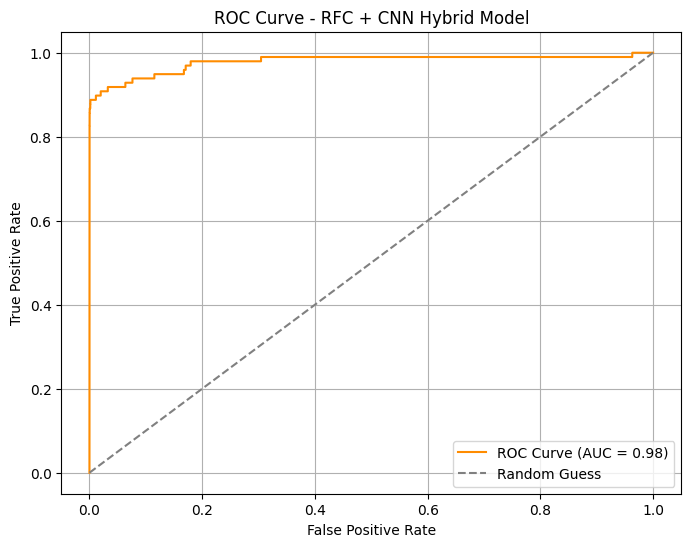

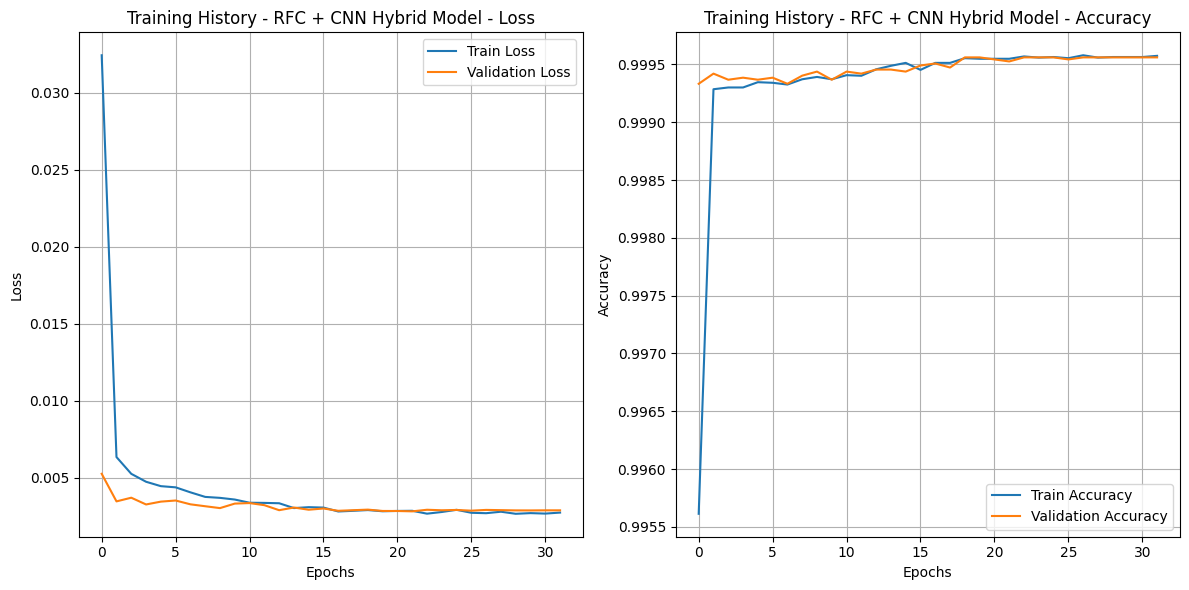

In [31]:
# Plotting

# ROC Curve
hybrid_probabilities = cnn_model.predict(X_test_combined)
plot_roc_curve(y_test, hybrid_probabilities, title="ROC Curve - RFC + CNN Hybrid Model")

# Training History
plot_training_history(history, title="Training History - RFC + CNN Hybrid Model")

In [33]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities
y_pred_proba = cnn_model.predict(X_test_combined).ravel()

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Find threshold for max F1
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Optimal Threshold: 0.72
